In [1]:
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
import sys
import csv
csv.field_size_limit(sys.maxsize)

131072

In [3]:
import pandas as pd
import numpy as np

df = pd.read_csv("train.csv", engine='python', error_bad_lines=False)
print(df.head(5))
print(df.shape)

   Id  Popularity                                       Page content
0   0          -1  <html><head><div class="article-info"> <span c...
1   1           1  <html><head><div class="article-info"><span cl...
2   2           1  <html><head><div class="article-info"><span cl...
3   3          -1  <html><head><div class="article-info"><span cl...
4   4          -1  <html><head><div class="article-info"><span cl...
(27643, 3)


The raw dataset is composed of 3 coloumns only, which are the index, popularity(-1 or 1), and the content written in html document. Trainning set here has total 27643 news ,and in the following sections we are going to extract useful informations from the content of news then make popularity prediction on testing set.

# Add Feature

Here is the feature extraction part, we use BeutifulSoup package in python for analysis of the html document. For each new, we extract several features and we list them below. <br>
- Page content: The whole content of a new.
- image: Number of images in a new.
- link: Number of links in a new.
- video: Number of video in a new.
- sport: Number of the words related to sport mentioned in a new. 
- date: The day of the week. 
- title_length: Number of words in title.
- text_length: Number of words in the content.
- hour: The time in hour when the new released.
- month: The month when the new released.
- topic: Keyword list in the end of the news.
- author: Author name of the new. 
- weekend: A binary variable. When the new is released in Saturday or Sunday, "weekend" = 1, or, "weekend" = -1.

What should be emphasized here is that we put the word in "topic" in front of the page content for 3 times, which further strengthen the importance of the topic.
Here, we only list the features we are going to use in this competition, the way how we deal with these features will be shown in later section.

In [5]:
from bs4 import BeautifulSoup

X = df["Page content"]
y = df["Popularity"]

author=[]
for text in X:
    soup = BeautifulSoup(text, 'html.parser')
    a_tags = soup.a
    a_tags = str(a_tags)
    x = a_tags.split("/")
    if(len(x)>=3):
        author.append(x[2])
    else:
        author.append("N")

topic=[]
for text in X:
    soup = BeautifulSoup(text, 'html.parser')
    foot = soup.footer
    a_tags = foot.find_all('a')
    temp=""
    for a in a_tags:
        a.string = a.string.replace(" ", "")
        temp = temp + ' ' + a.string
    temp = temp.strip()
    topic.append(temp)
    text = temp + ' ' + temp + ' ' + temp + ' ' + text
    
image = []
for text in X:
    image.append(text.count("img"))

link = []
for text in X:
    link.append(text.count("href"))

video = []
for text in X:
    video.append(text.count("iframe"))

sport = []
for text in X:
    sport.append(text.count("Entertainment"))

date = []
weekend = []
for text in X:
    a = text.find("datetime")
    date.append(text[a+10:a+13])
    if (text[a+10:a+13] == 'Sun' or text[a+10:a+13] == 'Sat'):
        weekend.append(1)
    else:
        weekend.append(-1)


title_length = []
text_length = []
hour = []
month = []
for text in X:
    soup = BeautifulSoup(text, 'html.parser')
    title_length.append(len(soup.h1.string))
    text_length.append(len(soup.get_text()))
    s = soup.time.string
    month.append(s[5:7])
    hour.append(s[11:13])

df['image'] = image
df['link'] = link
df['video'] = video
df['sport'] = sport
df['date'] = date
df['title_length'] = title_length
df['text_length'] = text_length
df['hour'] = hour
df['month'] = month
df['topic'] = topic
df['author'] = author
df['weekend'] = weekend


X = df[["Page content", 'image', 'link', 'video', 'sport', 'date', 'title_length', 'text_length', 'hour', 'month', 'topic', 'author', 'weekend']]

# Train Test Spilt

The work here is simple: split 20 percent of training set for validation set.

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=77)
print(X_train.shape)
print(type(X_train))

(22114, 13)
<class 'pandas.core.frame.DataFrame'>


# Training

This section is the training part. The first thing should be noted here is that we use a coloumn transformer from scikit-learn to generate the input which is enable to feed in the model. Coloumn transformer can deal with different type of input with different processor. For example, in our implementation, processor such as TF-IDF vectorizer, standard scaler, count vectorizer, one hot encoder, and normalizer are being used. We apply different processors on different features in order to maximize the information and at the same time minimize the size of input features.

- For the feature "Content", which is the most complicated one among all features, we use TF-IDF method. It can consider both the number of times a word appears in a document and the number of documents in the corpus that contain the word. With TF-IDF vectorizer, the work like stop word are no need to apply. The parameter "max_features" is set to 50000, which we find no more improvement for bigger max_features, and the parameter min_df is set to 3 so that we can avoid detecting some uncommon words.
- For the feature "topic", because that there are few number of words, we use "Bag of words" to represent the text data.
- For the featre used for counting the appearance number, we directly use standard scaler.
- For the feature indicates the value of time, we use one hot encoder.

The model we use here at final is logistic regression since it has the best performance on the public set on Kaggle.


In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA

def dummy(doc):
    return doc

processor = ColumnTransformer(
    [
        #('text', CountVectorizer(tokenizer=tokenizer_stem_nostop, preprocessor=preprocessor ,max_features=50000, min_df=3), 'Page content'),
        ('Content', TfidfVectorizer(max_features=50000, min_df=3), 'Page content'),
        ('image', StandardScaler(), ['image']),
        ('link', StandardScaler(), ['link']),
        ('video', StandardScaler(), ['video']),
        ('sport', StandardScaler(), ['sport']),
        ('date', OneHotEncoder(handle_unknown = "ignore"), ['date']),
        ('title_length', StandardScaler(), ['title_length']),
        ('text_length', StandardScaler(), ['text_length']),
        ('month', OneHotEncoder(handle_unknown = "ignore"), ['month']),
        ('hour', OneHotEncoder(handle_unknown = "ignore"), ['hour']),
        ('topic', CountVectorizer(tokenizer=dummy, preprocessor=dummy, max_features=2000, min_df=15), 'topic'),
        ('author', OneHotEncoder(handle_unknown = "ignore"), ['author']),
        ('weekend', Normalizer(), ['weekend']),
    ],
)

pipe = Pipeline(
    steps=[
        ('processor', processor),
        ('classifier', LogisticRegression(solver = "liblinear", max_iter=1000)),
    ],
)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
y_pred_proba = pipe.predict_proba(X_test)
accuracy_score(y_test, y_pred)

0.552722011213601

# ROC curve

Here, we use the validation set we split out to plot the ROC curve.

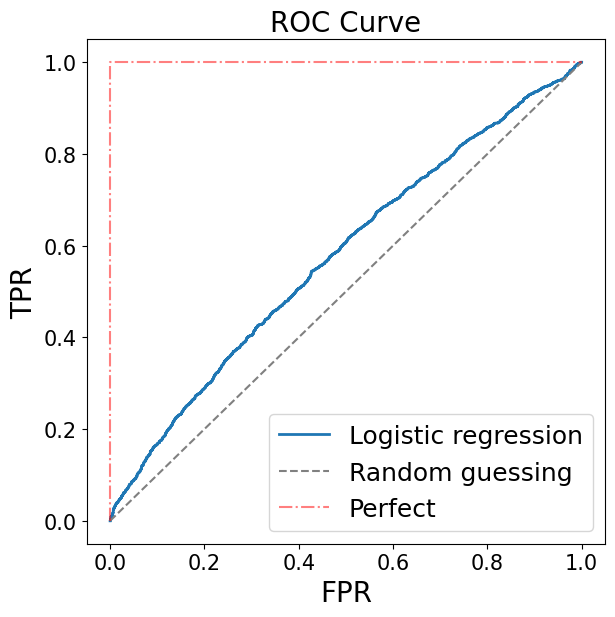

AUC: 0.5757


In [14]:
from sklearn import metrics
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6,6))
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba[:, 1], pos_label=1)
plt.plot(fpr, tpr, lw=2, label='Logistic regression')
plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color='gray',
         label='Random guessing')

plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle='-.',
         alpha=0.5,
         color='red',
         label='Perfect')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.tight_layout()
plt.legend(loc=4, prop={'size': 18})
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
plt.show()

print('AUC: %.4f' % metrics.auc(fpr, tpr))

# For Kaggle Test Data

In the final part, we use the model trained by training set after split to make prediction on the testing set of Kaggle and the result is saved in y_pred.csv

In [17]:
df_test = pd.read_csv("test.csv", engine='python', error_bad_lines=False)

author=[]
for text in df_test['Page content']:
    soup = BeautifulSoup(text, 'html.parser')
    a_tags = soup.a
    a_tags = str(a_tags)
    x = a_tags.split("/")
    if(len(x)>=3):
        author.append(x[2])
    else:
        author.append("N")

topic=[]
for text in df_test['Page content']:
    soup = BeautifulSoup(text, 'html.parser')
    foot = soup.footer
    a_tags = foot.find_all('a')
    temp=""
    for a in a_tags:
        a.string = a.string.replace(" ", "")
        temp = temp + ' ' + a.string
    temp = temp.strip()
    topic.append(temp)
    text = temp + ' ' + temp + ' ' + temp + ' ' + text

image = []
for text in df_test['Page content']:
    image.append(text.count("img"))

link = []
for text in df_test['Page content']:
    link.append(text.count("href"))

video = []
for text in df_test['Page content']:
    video.append(text.count("iframe"))

sport = []
for text in df_test['Page content']:
    sport.append(text.count("sport"))

date = []
weekend = []
for text in df_test['Page content']:
    a = text.find("datetime")
    date.append(text[a+10:a+13])
    if (text[a+10:a+13] == 'Sun' or text[a+10:a+13] == 'Sat'):
        weekend.append(1)
    else:
        weekend.append(-1)

title_length = []
text_length = []
hour = []
month = []
for text in df_test['Page content']:
    soup = BeautifulSoup(text, 'html.parser')
    title_length.append(len(soup.h1.string))
    text_length.append(len(soup.get_text()))
    s = soup.time.string
    if (s):
        month.append(s[5:7])
        hour.append(s[11:13])
    else:
        month.append("N")
        hour.append("N")
df_test['image'] = image
df_test['link'] = link
df_test['video'] = video
df_test['sport'] = sport
df_test['date'] = date
df_test['title_length'] = title_length
df_test['text_length'] = text_length
df_test['hour'] = hour
df_test['month'] = month
df_test['topic'] = topic
df_test['author'] = author
df_test['weekend'] = weekend


#print(date)
df_test.drop(['Id'], axis=1)
print(df_test.shape)
pred = pipe.predict_proba(df_test[["Page content", 'image', 'link', 'video', 'sport', 'date', 'title_length', 'text_length', 'hour', 'month', 'topic','author', 'weekend']])

(11847, 14)


In [18]:
print(pred)
pd.DataFrame(pred[:,1], columns=['Popularity']).to_csv('y_pred.csv')

[[0.50540011 0.49459989]
 [0.3831488  0.6168512 ]
 [0.63305858 0.36694142]
 ...
 [0.48699997 0.51300003]
 [0.60117255 0.39882745]
 [0.59902152 0.40097848]]
